### from previous section, we created our first version of NodeInvasionEnv as below:

In [116]:
### node_graph.py
class GraphNode:
    def __init__(self, name):
        self.name = name
        self.edges = []

    def __str__(self):
        return self.name

    def __repr__(self):
        return f"GraphNode(name={self.name}, edges={self.edges})"


# create a class of Graph
class Graph:
    def __init__(self, nodeName, nodeClass=GraphNode):
        # initialize graph
        self.nodeClass = nodeClass
        self.mainNode = self.nodeClass(nodeName)
        self.adj_list = {self.mainNode.name: []}
        self.nodes = {self.mainNode.name: self.mainNode}

    # add node
    def addNode(self, target, nodeName: str):
        assert target in self.adj_list, "Target node not exist"
        targetNode = self.nodes[target]

        node = self.nodes[nodeName] if nodeName in self.adj_list.keys() else self.nodeClass(nodeName)

        # update edges for target node and new node
        targetNode.edges.append(node.name)
        node.edges.append(targetNode.name)

        # update adjacency list
        self.adj_list[node.name] = node.edges
        self.adj_list[targetNode.name] = targetNode.edges

        # update nodes
        if node.name not in self.nodes.keys():
            self.nodes[node.name] = node

    def __repr__(self):
        return f"Graph(mainNode={self.mainNode})"

In [117]:
### components.py

import random


class WarGraphNode(GraphNode):
    def __init__(self, name, initial_energy=0):
        super().__init__(name)
        self.initial_energy = initial_energy
        self.energy = self.initial_energy
        self.occupied = self.energy > 0

    def _reset_all(self):
        self.energy = self.initial_energy
        self.occupied = self.energy > 0
        self.edges = []

    def reset(self):
        self.energy = self.initial_energy
        self.occupied = self.energy > 0

    def __repr__(self):
        return f"WarGraphNode(name={self.name}, energy={self.energy}, occupied={self.occupied}, edges={self.edges})"


# WarGraph class
class WarGraph(Graph):
    def __init__(self, nodeName, random_mainNode=True):
        super().__init__(nodeName, WarGraphNode)
        self.random_mainNode = random_mainNode
        headEnergy = 100 if not self.random_mainNode else 0
        self.headNode = self.nodeClass(nodeName,
                                       headEnergy)  # self.mainNode -> self.headNode as this node may not be mainNode
        self.adj_list = {self.headNode.name: []}
        self.nodes = {self.headNode.name: self.headNode}

        self.initialized = False

    # after reset_nodes(), mainNode need to be reintialized again
    def reset_nodes(self):
        for node in self.nodes.values():
            node.energy = 0
            node.occupied = False
        self.initialized = False

    def initialize_mainNode(self, nodeName=None):
        if self.initialized:
            return
            # param nodeName has higher priority than self.random_mainNode
        if not nodeName:
            assert self.random_mainNode, "Please specify nodeName for mainNode or set self.random_mainNode as True"
            nodeName = random.choice(list(self.nodes.keys()))
        else:
            assert nodeName in self.nodes.keys(), "Specified nodeName not exist"
        mainNode = self.nodes[nodeName]
        mainNode.energy = 100
        mainNode.occupied = True
        self.initialized = True
        return mainNode

    def diffusion(self, selected_nodeName: str, target_nodeName: str):
        assert self.initialized, "Please call self.initialize_mainNode() before diffusion operation"
        assert not selected_nodeName == target_nodeName, "Selecting same selected node and target node is invalid"
        assert selected_nodeName in self.adj_list, "Selected node not exist"
        assert target_nodeName in self.adj_list, "Target node not exist"
        assert target_nodeName in self.nodes[selected_nodeName].edges, "Target node is not an edge of selected node"
        diffusable_nodes = [k for k, v in self.nodes.items() if v.energy > 50]
        # print("Diffusable nodes:", diffusable_nodes)

        selected_node = self.nodes[selected_nodeName]
        assert selected_node.energy > 50, "Not enough energy"

        # print("All good")
        # print("Selected node edges:", selected_node.edges)

        # select one of the edge and diffuse selected node's energy
        target_node = self.nodes[target_nodeName]
        assert not target_node.occupied, "Target node has been occupied"

        target_node.energy = 50
        target_node.occupied = True
        selected_node.energy -= 50

    def __repr__(self):
        return f"WarGraph(headNode={self.headNode})"


graph = WarGraph('d')

graph.addNode('d', 'a')
graph.addNode('d', 'b')
graph.addNode('d', 'f')
graph.addNode('d', 'e')
graph.addNode('d', 'g')

graph.addNode('e', 'b')
graph.addNode('e', 'g')
graph.addNode('e', 'c')
graph.addNode('e', 'h')

preset1 = graph
if __name__ == '__main__':
    print(preset1.nodes)


{'d': WarGraphNode(name=d, energy=0, occupied=False, edges=['a', 'b', 'f', 'e', 'g']), 'a': WarGraphNode(name=a, energy=0, occupied=False, edges=['d']), 'b': WarGraphNode(name=b, energy=0, occupied=False, edges=['d', 'e']), 'f': WarGraphNode(name=f, energy=0, occupied=False, edges=['d']), 'e': WarGraphNode(name=e, energy=0, occupied=False, edges=['d', 'b', 'g', 'c', 'h']), 'g': WarGraphNode(name=g, energy=0, occupied=False, edges=['d', 'e']), 'c': WarGraphNode(name=c, energy=0, occupied=False, edges=['e']), 'h': WarGraphNode(name=h, energy=0, occupied=False, edges=['e'])}


In [118]:
### main.py
import gym
import numpy as np
from gym.spaces import MultiDiscrete
import matplotlib.pyplot as plt


class NodeInvasionEnv(gym.Env):
    def __init__(self, max_timestep=200, gameGraph=preset1, mainNode='e', delta_energy=1):
        self.max_timestep = max_timestep
        self.delta_energy = delta_energy
        self.timestep = 0
        self.gameGraph = gameGraph
        self.gameGraph.reset_nodes()
        self.gameGraph.initialize_mainNode(mainNode)   # mainNode can be changed later
        self.graphNodes = self.gameGraph.nodes
        self.graphNodeIdx = {idx: i for idx, i in enumerate(list(gameGraph.nodes.keys()))}   # index for each nodes
        self.obs = np.array([(node.energy, int(node.occupied)) for node in self.graphNodes.values()])
        self.n_nodes = self.obs.shape[0]
        self.observation_space = MultiDiscrete([101, 2])
        self.action_space = MultiDiscrete([self.obs.shape[0]] * 2)

    def reset(self):
        self.timestep = 0
        self.gameGraph.reset_nodes()
        self.gameGraph.initialize_mainNode('e')   # mainNode can be changed later
        return np.array([(node.energy, int(node.occupied)) for node in self.gameGraph.nodes.values()])

    # update energy per second
    def __update_energy(self):
        for gNode in self.graphNodes.values():
            if gNode.occupied and gNode.energy < 100:
                gNode.energy += self.delta_energy

    def step(self, action):
        # 1. diffuse energy
        selected_nodeName, target_nodeName = self.graphNodeIdx[action[0]], self.graphNodeIdx[action[1]]
        # print(selected_nodeName, target_nodeName)
        try:
            self.gameGraph.diffusion(selected_nodeName, target_nodeName)
            # print(gameGraph.nodes)
            # reward = 0
            reward = int(sum(self.obs[:, 0]) / self.n_nodes)
        except AssertionError as ae:
            reward = -1

        # 2. update energy
        self.__update_energy()

        # update obs
        self.obs = np.array([(node.energy, int(node.occupied)) for node in self.graphNodes.values()])

        # update timestep
        self.timestep += 1

        # truncation
        truncation = self.timestep >= self.max_timestep

        # termination
        termination = sum(self.obs[:, 0]) / self.n_nodes == 100

        done = truncation or termination

        # update reward if done
        if done:
            reward = int(sum(self.obs[:, 0]) / self.n_nodes)

        # scale reward
        # reward = 0.01 * reward

        return self.obs, reward, done, dict()

    @staticmethod
    def visualize_rewards(rewards):
        plt.plot(rewards)
        plt.xlabel("Timestep")
        plt.ylabel("Reward")
        plt.show()

    def render(self, mode="human"):
        raise NotImplementedError

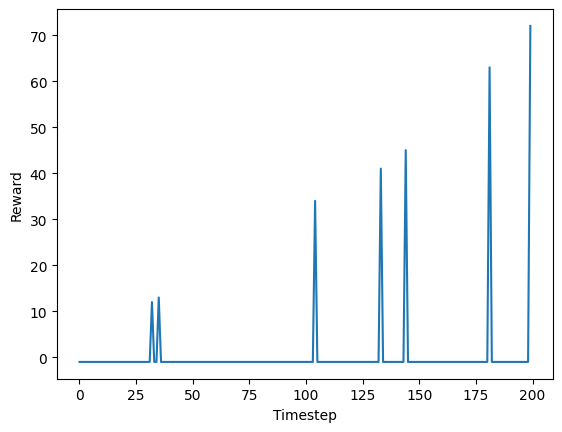

In [119]:
env = NodeInvasionEnv()

rewards = []
obs_records = []

obs = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    next_obs, reward, done, _ = env.step(action)
    obs = next_obs

    # record rewards and obs
    rewards.append(reward)
    obs_records.append(obs)

env.visualize_rewards(rewards)

### In this section, our target is to __expand number of node in our graph__, by allowing __random generation of node graph__.

In [120]:
# number of nodes contained in preset above
len(preset1.nodes)

8

### 1. randomly generate node graph

In [121]:
# we want to generate a node graph with 'n_nodes' nodes, where each node contains maximum of 'n_edges' edges
n_nodes = 50
n_edges = 5

In [122]:
# modify class
class WarGraphNode(GraphNode):
    def __init__(self, name, n_edges=3, initial_energy=0):
        super().__init__(name)
        self.initial_energy = initial_energy
        self.energy = self.initial_energy
        self.occupied = self.energy > 0
        self.n_edges = n_edges
        self.full = False

    def _reset_all(self):
        self.energy = self.initial_energy
        self.occupied = self.energy > 0
        self.edges = []
        self.full = False

    def reset(self):
        self.energy = self.initial_energy
        self.occupied = self.energy > 0
        self.full = False

    def __repr__(self):
        return f"WarGraphNode(name={self.name}, energy={self.energy}, occupied={self.occupied}, edges={self.edges}, n_edges={self.n_edges}, full={self.full})"


# WarGraph class
class WarGraph(Graph):
    def __init__(self, nodeName, n_edges=3, random_mainNode=True):
        super().__init__(nodeName, WarGraphNode)
        self.random_mainNode = random_mainNode
        headEnergy = 100 if not self.random_mainNode else 0
        self.n_edges = n_edges
        self.headNode = self.nodeClass(name=nodeName, n_edges=self.n_edges,
                                       initial_energy=headEnergy)  # self.mainNode -> self.headNode as this node may not be mainNode
        self.adj_list = {self.headNode.name: []}
        self.nodes = {self.headNode.name: self.headNode}
        self.available_nodes = {self.headNode.name: self.headNode}

        self.initialized = False

    # after reset_nodes(), mainNode need to be reintialized again
    def reset_nodes(self):
        for node in self.nodes.values():
            node.energy = 0
            node.occupied = False
        self.initialized = False

    def initialize_mainNode(self, nodeName=None):
        if self.initialized:
            return
            # param nodeName has higher priority than self.random_mainNode
        if not nodeName:
            assert self.random_mainNode, "Please specify nodeName for mainNode or set self.random_mainNode as True"
            nodeName = random.choice(list(self.nodes.keys()))
        else:
            assert nodeName in self.nodes.keys(), "Specified nodeName not exist"
        mainNode = self.nodes[nodeName]
        mainNode.energy = 100
        mainNode.occupied = True
        self.initialized = True
        return mainNode

    def diffusion(self, selected_nodeName: str, target_nodeName: str):
        assert self.initialized, "Please call self.initialize_mainNode() before diffusion operation"
        assert not selected_nodeName == target_nodeName, "Selecting same selected node and target node is invalid"
        assert selected_nodeName in self.adj_list, "Selected node not exist"
        assert target_nodeName in self.adj_list, "Target node not exist"
        assert target_nodeName in self.nodes[selected_nodeName].edges, "Target node is not an edge of selected node"
        diffusable_nodes = [k for k, v in self.nodes.items() if v.energy > 50]
        # print("Diffusable nodes:", diffusable_nodes)

        selected_node = self.nodes[selected_nodeName]
        assert selected_node.energy > 50, "Not enough energy"

        # print("All good")
        # print("Selected node edges:", selected_node.edges)

        # select one of the edge and diffuse selected node's energy
        target_node = self.nodes[target_nodeName]
        assert not target_node.occupied, "Target node has been occupied"

        target_node.energy = 50
        target_node.occupied = True
        selected_node.energy -= 50

    def __repr__(self):
        return f"WarGraph(headNode={self.headNode})"

In [123]:
n_nodes = 30
n_edges = 5

graph = WarGraph(0, n_edges=n_edges)
available_nodes = {graph.headNode.name: graph.headNode}
for n in range(1, n_nodes):
  # create a newNode
  newNode = WarGraphNode(n, n_edges=n_edges)

  # randomly select a node where its capacity is not full(not node.full)
  selected_nodeName = random.choice(list(available_nodes.keys())[-10:])   # only select from last 10 available nodes
  selectedNode = available_nodes[selected_nodeName]

  # update their edges
  newNode.edges.append(selected_nodeName)
  selectedNode.edges.append(n)

  # add new node to graph.nodes
  graph.nodes[n] = newNode

  # update available nodes
  available_nodes[n] = newNode

  # if node.full, remove its key from available nodes
  newNode.full = len(newNode.edges) == newNode.n_edges
  if newNode.full:
    _ = available_nodes.pop(n)
  selectedNode.full = len(selectedNode.edges) == selectedNode.n_edges
  if selectedNode.full:
    _ = available_nodes.pop(selectedNode.name)

In [ ]:
graph.nodes

In [542]:
# add to WarGraph as a function
# WarGraph class
class WarGraph(Graph):
    def __init__(self, nodeName, n_edges=3, random_mainNode=True):
        super().__init__(nodeName, WarGraphNode)
        self.random_mainNode = random_mainNode
        headEnergy = 100 if not self.random_mainNode else 0
        self.n_edges = n_edges
        self.headNode = self.nodeClass(name=nodeName, n_edges=self.n_edges,
                                       initial_energy=headEnergy)  # self.mainNode -> self.headNode as this node may not be mainNode
        self.adj_list = {self.headNode.name: []}
        self.nodes = {self.headNode.name: self.headNode}
        self.available_nodes = {self.headNode.name: self.headNode}

        self.initialized = False

    # after reset_nodes(), mainNode need to be reintialized again
    def reset_nodes(self):
        for node in self.nodes.values():
            node.reset()
        self.initialized = False

    def initialize_mainNode(self, nodeName=None):
        if self.initialized:
            return
            # param nodeName has higher priority than self.random_mainNode
        if not nodeName:
            assert self.random_mainNode, "Please specify nodeName for mainNode or set self.random_mainNode as True"
            nodeName = random.choice(list(self.nodes.keys()))
        else:
            assert nodeName in self.nodes.keys(), "Specified nodeName not exist"
        mainNode = self.nodes[nodeName]
        mainNode.energy = 100
        mainNode.occupied = True
        self.initialized = True
        return mainNode

    def generate_graph(self, n_nodes, n_edges=5):
      available_nodes = {self.headNode.name: self.headNode}
      for n in range(1, n_nodes):
        # create a newNode
        newNode = WarGraphNode(n, n_edges=n_edges)

        # randomly select a node where its capacity is not full(not node.full)
        selected_nodeName = random.choice(list(available_nodes.keys())[-10:])   # only select from last 10 available nodes
        selectedNode = available_nodes[selected_nodeName]

        # update their edges
        newNode.edges.append(selected_nodeName)
        selectedNode.edges.append(n)

        # add new node to graph.nodes
        self.nodes[n] = newNode

        # update available nodes
        available_nodes[n] = newNode

        # update adjacency list
        self.adj_list[newNode.name] = newNode.edges
        self.adj_list[selectedNode.name] = selectedNode.edges


        # if node.full, remove its key from available nodes
        newNode.full = len(newNode.edges) == newNode.n_edges
        if newNode.full:
          _ = available_nodes.pop(n)
        selectedNode.full = len(selectedNode.edges) == selectedNode.n_edges
        if selectedNode.full:
          _ = available_nodes.pop(selectedNode.name)

      return self.nodes

    def diffusion(self, selected_nodeName: str, target_nodeName: str):
        assert self.initialized, "Please call self.initialize_mainNode() before diffusion operation"
        assert not selected_nodeName == target_nodeName, "Selecting same selected node and target node is invalid"
        assert selected_nodeName in self.adj_list, "Selected node not exist"
        assert target_nodeName in self.adj_list, "Target node not exist"
        assert target_nodeName in self.nodes[selected_nodeName].edges, "Target node is not an edge of selected node"
        diffusable_nodes = [k for k, v in self.nodes.items() if v.energy > 50]
        # print("Diffusable nodes:", diffusable_nodes)

        selected_node = self.nodes[selected_nodeName]
        assert selected_node.energy > 50, "Not enough energy"

        # print("All good")
        # print("Selected node edges:", selected_node.edges)

        # select one of the edge and diffuse selected node's energy
        target_node = self.nodes[target_nodeName]
        assert not target_node.occupied, "Target node has been occupied"

        target_node.energy = 50
        target_node.occupied = True
        selected_node.energy -= 50

    def __repr__(self):
        return f"WarGraph(headNode={self.headNode})"

In [599]:
graph = WarGraph('S', n_edges=3, random_mainNode=False)
nodes = graph.generate_graph(60, n_edges=3)

In [ ]:
nodes

### visualize graph using networkx

In [128]:
import networkx as nx

In [271]:
# add node with their attributes
# list of supported colors: https://matplotlib.org/stable/gallery/color/named_colors.html
# G = nx.Graph()
# node_color = []
# for node in nodes.values():
#   color = 'lightgray' if node.energy == 0 else 'lightskyblue'
#   node_color.append(color)
#   G.add_node(node.name, energy=node.energy, full=node.full)

G = nx.Graph()
node_color_dict = dict()
for node in nodes.values():
  color = 'lightgray' if node.energy == 0 else 'lightskyblue'
  node_color_dict[node.name] = color
  G.add_node(node.name, energy=node.energy, full=node.full)
node_color = list(node_color_dict.values())

In [274]:
labels = nx.get_node_attributes(G, 'energy')

In [275]:
for node in nodes.values():
  u = node.name
  for v in node.edges:
    G.add_edge(u, v)

In [276]:
import math

In [297]:
def render(G):
  global node_color
  labels = nx.get_node_attributes(G, 'energy')

  plt.figure(figsize=(17, 17))
  subax1 = plt.subplot(224)

  # set seed to fix position of all nodes
  # nx.draw(G, node_color=node_color, pos=nx.spring_layout(G, seed=1), labels=labels, font_weight='bold')

  optimal_distance = (1 / math.sqrt(G.number_of_nodes())) * 2   # double of default optimal distance
  nx.draw_networkx(G, node_color=node_color, pos=nx.spring_layout(G, seed=1, k=optimal_distance),
                  labels=labels, font_size=10, font_weight='bold', node_size=350)

  # return fig

# plt.draw()
# plt.savefig("Nodes1.png")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


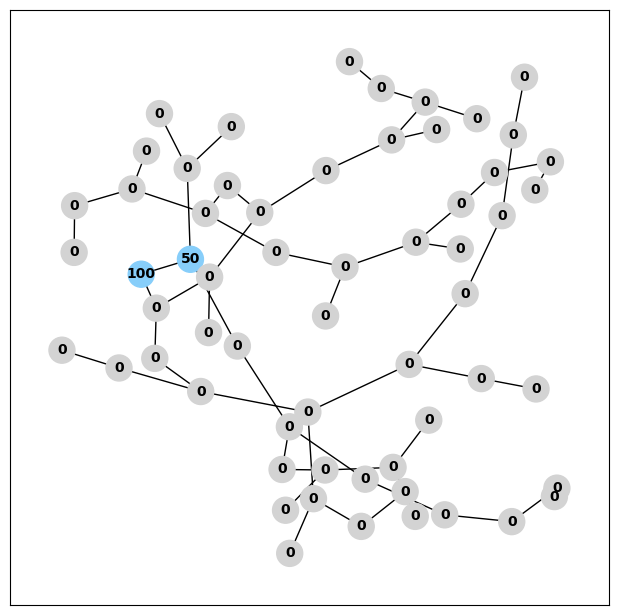

In [296]:
labels = nx.get_node_attributes(G, 'energy')

fig = plt.figure(figsize=(17, 17))
subax1 = plt.subplot(224)

# set seed to fix position of all nodes
# nx.draw(G, node_color=node_color, pos=nx.spring_layout(G, seed=1), labels=labels, font_weight='bold')

optimal_distance = (1 / math.sqrt(G.number_of_nodes())) * 2   # double of default optimal distance
nx.draw_networkx(G, node_color=node_color, pos=nx.spring_layout(G, seed=1, k=optimal_distance),
                labels=labels, font_size=10, font_weight='bold', node_size=350)

plt.savefig("eg1.png", bbox_inches='tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


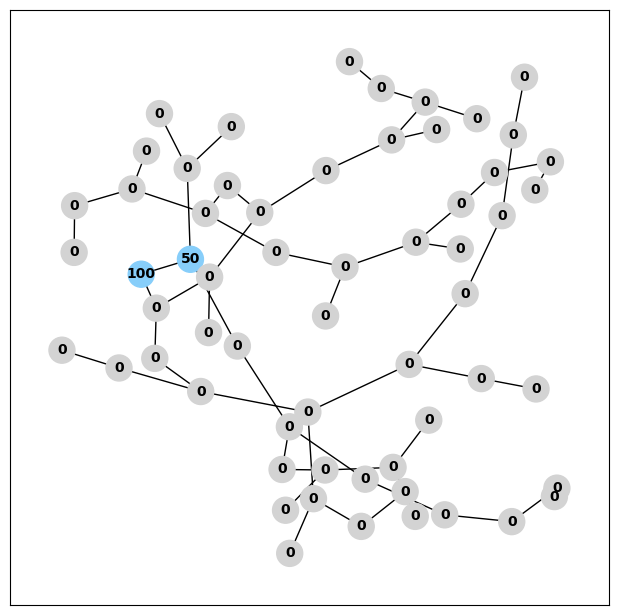

In [291]:
fig = render(G)

In [258]:
# a function to get index of key in dict
def keyindex(d: dict, key):
  i = 0
  for k, v in d.items():
    if k == key:
      return i
    i += 1
  return -1

In [279]:
G.nodes()[1]['energy'] = 50
node_color[keyindex(node_color_dict, 1)] = 'lightskyblue'

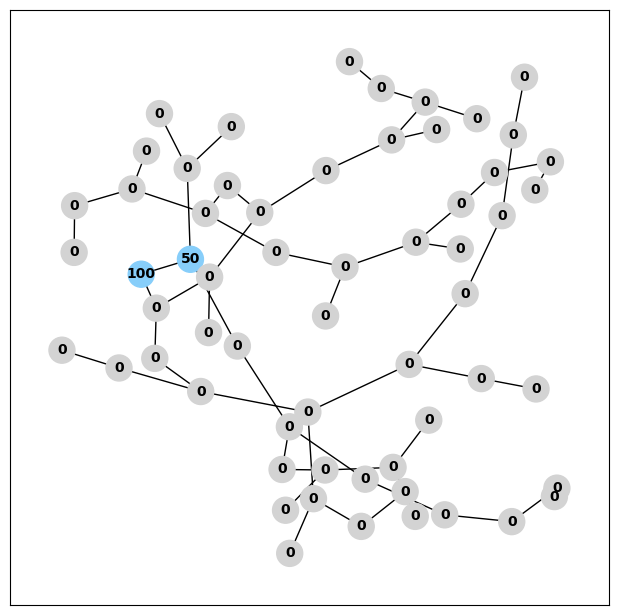

In [280]:
render(G)

In [282]:
import os
os.mkdir("nodeEpisode")

In [ ]:
import shutil
# shutil.rmtree()

In [303]:
# os.mkdir("nodeEpisode/01")
for i in range(10):
  render(G)

  plt.savefig(f'nodeEpisode/01/{i}.png', bbox_inches='tight')
  plt.close()

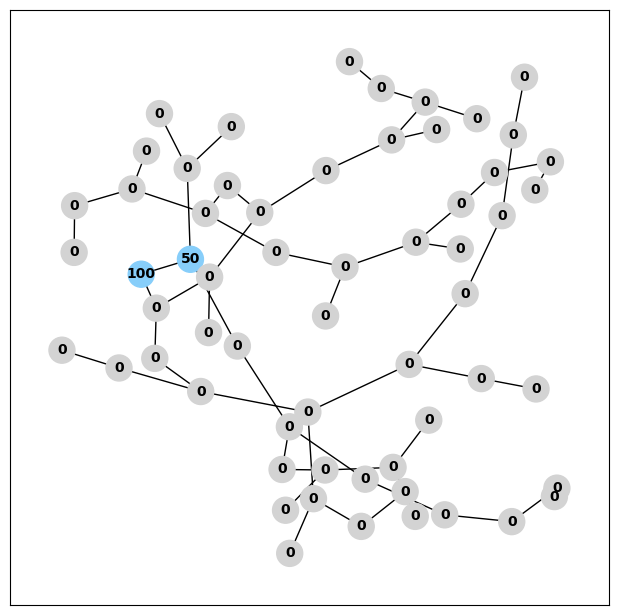

In [360]:
# importing PIL
from PIL import Image

# Read image
img = Image.open("nodeEpisode/01/1.png")
img

In [308]:
W, H = img.size
W, H

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(618, 615)

In [355]:
# try to save video
from matplotlib.animation import PillowWriter

  and should_run_async(code)



In [365]:
img = plt.imread("nodeEpisode/01/9.png")

  and should_run_async(code)



AttributeError: ignored

In [513]:
paths = sorted(os.listdir("nodeEpisode/02"), key=lambda x: x.split('.')[0].zfill(3))
images = [plt.imread(os.path.join("nodeEpisode/02", path)) for path in paths]

  and should_run_async(code)



In [ ]:
images

In [370]:
from matplotlib import animation

  and should_run_async(code)



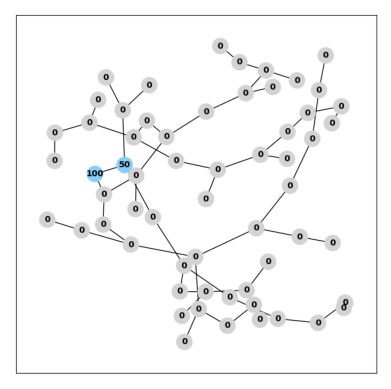

In [381]:
fig, ax = plt.subplots()
rng = np.random.default_rng(19680801)
data = np.array([20, 20, 20, 20])
x = np.array([1, 2, 3, 4])
plt.axis('off')
artists = []
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple']
for i in range(20):
    container = ax.imshow(img)
    artists.append([container])


ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
plt.show()

In [382]:
HTML(ani.to_html5_video())

### time to try for an episode!

In [384]:
from gym.spaces import MultiDiscrete

  and should_run_async(code)



In [389]:
def update_energy():
    for gNode in graph.nodes.values():
        if gNode.occupied and gNode.energy < 100:
            gNode.energy += 1

In [541]:
graph.available_nodes

  and should_run_async(code)



{'S': WarGraphNode(name=S, energy=100, occupied=True, edges=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], n_edges=10, full=True),
 1: WarGraphNode(name=1, energy=0, occupied=False, edges=['S'], n_edges=2, full=False),
 2: WarGraphNode(name=2, energy=0, occupied=False, edges=['S'], n_edges=2, full=False),
 3: WarGraphNode(name=3, energy=0, occupied=False, edges=['S'], n_edges=2, full=False),
 4: WarGraphNode(name=4, energy=0, occupied=False, edges=['S'], n_edges=2, full=False),
 5: WarGraphNode(name=5, energy=0, occupied=False, edges=['S'], n_edges=2, full=False),
 6: WarGraphNode(name=6, energy=0, occupied=False, edges=['S'], n_edges=2, full=False),
 7: WarGraphNode(name=7, energy=0, occupied=False, edges=['S'], n_edges=2, full=False),
 8: WarGraphNode(name=8, energy=0, occupied=False, edges=['S'], n_edges=2, full=False),
 9: WarGraphNode(name=9, energy=0, occupied=False, edges=['S'], n_edges=2, full=False),
 10: WarGraphNode(name=10, energy=0, occupied=False, edges=['S'], n_edges=2, full=False)}

In [583]:
# initialize graph
graph = WarGraph('S', n_edges=10, random_mainNode=False)
nodes = graph.generate_graph(30, n_edges=2)

graph.reset_nodes()
graph.initialize_mainNode('S')

graphNodeIdx = {idx: i for idx, i in enumerate(list(graph.nodes.keys()))}   # index for each nodes
n_nodes = len(graph.nodes)
action_space = MultiDiscrete([n_nodes] * 2)

timestep = 0
max_timestep = 150

In [ ]:
nodes

In [584]:
# initialize nx graph
G = nx.Graph()
node_color_dict = dict()
for node in nodes.values():
  color = 'lightgray' if not node.occupied else 'lightskyblue'
  node_color_dict[node.name] = color
  G.add_node(node.name, energy=node.energy, full=node.full, occupied=node.occupied)
node_color = list(node_color_dict.values())

labels = nx.get_node_attributes(G, 'energy')

for node in nodes.values():
  u = node.name
  for v in node.edges:
    G.add_edge(u, v)

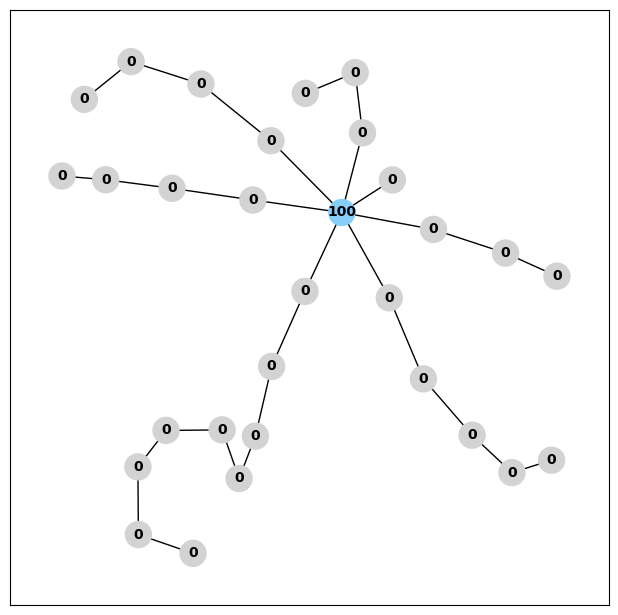

In [585]:
render(G)

In [586]:
import shutil
shutil.rmtree("nodeEpisode/02")
os.mkdir("nodeEpisode/02")

In [587]:
from tqdm import tqdm

bar = tqdm(total=150)

  0%|          | 0/150 [00:00<?, ?it/s]

In [550]:
graph.available_nodes

  and should_run_async(code)



{'S': True}

In [560]:
occupied_nodes = [node for _, node in graph.nodes.items() if node.occupied]

  and should_run_async(code)



[WarGraphNode(name=S, energy=2, occupied=True, edges=[1, 2, 9, 24, 25, 26, 28], n_edges=10, full=False),
 WarGraphNode(name=24, energy=52, occupied=True, edges=['S'], n_edges=2, full=False),
 WarGraphNode(name=25, energy=51, occupied=True, edges=['S'], n_edges=2, full=False)]

In [588]:
done = False

while not done:
  selected_nodeName = random.choice(list(graph.available_nodes.keys()))
  selectedNode = graph.nodes[selected_nodeName]
  target_nodeName = random.choice(selectedNode.edges)
  targetNode = graph.nodes[target_nodeName]
  # print(selected_nodeName, target_nodeName)
  try:
    graph.diffusion(selected_nodeName, target_nodeName)

    # change color of diffused node upon effective diffusion
    G.nodes()[selected_nodeName]['energy'] -= 50
    G.nodes()[target_nodeName]['energy'] = 50
    G.nodes()[target_nodeName]['occupied'] = True
    node_color[keyindex(node_color_dict, target_nodeName)] = 'lightskyblue'

    # update graph.available_nodes
    occupied_nodes = [node for _, node in graph.nodes.items() if node.occupied]
    for node in occupied_nodes:
      if node.energy <= 50 and node.name in graph.available_nodes.keys():
        _ = graph.available_nodes.pop(node.name)
      else:
        graph.available_nodes[node.name] = node

  except AssertionError as ae:
    pass

  # 2. update energy
  update_energy()

  # update G
  for name, node in G.nodes(data=True):
    if node['occupied'] and node['energy'] < 100:
      node['energy'] += 1

  # render and save
  render(G)
  plt.savefig(f'nodeEpisode/02/{timestep}.png', bbox_inches='tight')
  plt.close()

  # update obs
  # self.obs = np.array([(node.energy, int(node.occupied)) for node in self.graphNodes.values()])

  # update timestep
  timestep += 1

  bar.update(1)

  # truncation
  done = timestep >= max_timestep

100%|██████████| 150/150 [00:48<00:00,  3.46it/s]

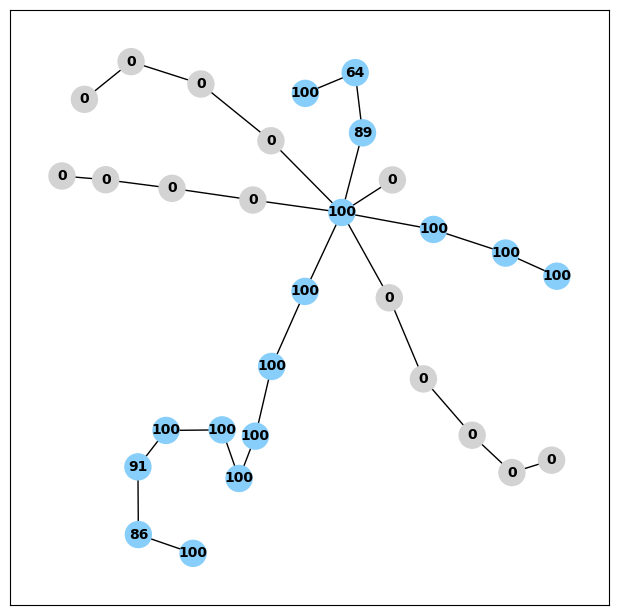

In [589]:
render(G)

In [593]:
paths = sorted(os.listdir("nodeEpisode/02"), key=lambda x: x.split('.')[0].zfill(3))
images = [plt.imread(os.path.join("nodeEpisode/02", path)) for path in paths]

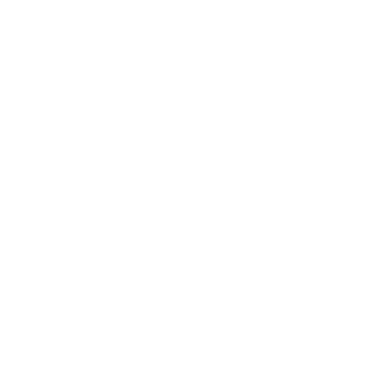

In [594]:
# visualize graph as video
fig, ax = plt.subplots()
rng = np.random.default_rng(19680801)
data = np.array([20, 20, 20, 20])
x = np.array([1, 2, 3, 4])
plt.axis('off')
artists = []
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple']
for i in range(max_timestep):
    img = images[i]
    container = ax.imshow(img)
    artists.append([container])

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
# plt.show()

In [595]:
HTML(ani.to_html5_video())

### integrate render() function to the whole environment